In [4]:
import sys
!{sys.executable} -m pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /private/var/folders/n2/lnl5yrk105gfw2pkhcksyj900000gn/T/pip-req-build-qatabtd6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/n2/lnl5yrk105gfw2pkhcksyj900000gn/T/pip-req-build-qatabtd6
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=ebd11144e2a87ae0eb5b2affb0305209c7657b62f0b36aaf5763a4dd4d1cc47f
  Stored in directory: /private/var/folders/n2/lnl5yrk105gfw2pkhcksyj900000gn/T/pip-ephem-wheel-cache-zgbvp3l8/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [13]:
# initialization
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

In [14]:
import torch

# if you have CUDA set it to the active device like this
device = "cuda" if torch.cuda.is_available() else "cpu"
# move the model to the device
model.to(device)

device

'cpu'

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

In [24]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [32]:
labels = set(dataset['train']['label'])


In [36]:
len(labels)

37

In [33]:
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a german shorthaired',
 'a photo of a japanese chin',
 'a photo of a leonberger',
 'a photo of a Bengal',
 'a photo of a Birman',
 'a photo of a Bombay',
 'a photo of a american bulldog',
 'a photo of a British Shorthair',
 'a photo of a miniature pinscher',
 'a photo of a wheaten terrier',
 'a photo of a boxer',
 'a photo of a Siamese',
 'a photo of a beagle',
 'a photo of a havanese',
 'a photo of a saint bernard',
 'a photo of a Ragdoll',
 'a photo of a Egyptian Mau',
 'a photo of a chihuahua',
 'a photo of a scottish terrier',
 'a photo of a Sphynx',
 'a photo of a yorkshire terrier',
 'a photo of a american pit bull terrier',
 'a photo of a Abyssinian',
 'a photo of a english cocker spaniel',
 'a photo of a english setter',
 'a photo of a Persian',
 'a photo of a great pyrenees',
 'a photo of a shiba inu',
 'a photo of a pomeranian',
 'a photo of a basset hound',
 'a photo of a keeshond',
 'a photo of a pug',
 'a photo of a Russian Blue',
 'a photo of a newfoundland',

In [34]:
# initialization
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

In [38]:
# create label tokens
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:37]

tensor([49406,   320,  1125,   539,   320,  4710, 37397, 21938, 49407, 49407])

In [39]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(37, 512)

In [40]:
label_emb.min(), label_emb.max()

(-1.4295442, 5.4778085)

In [41]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.62339264, 0.572986)

In [43]:
image = processor(
    text=None,
    images=dataset['train'][0]['image'],
    return_tensors='pt'
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

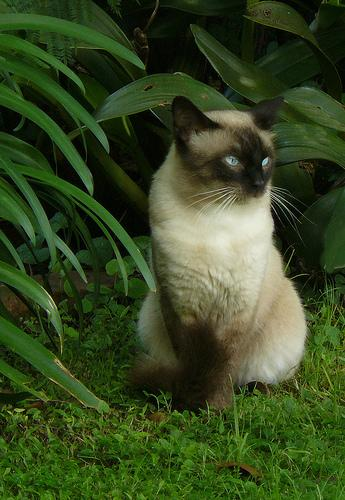

In [53]:
dataset['train'][0]['image']

In [44]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [45]:
img_emb = img_emb.detach().cpu().numpy()

In [46]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 37)

In [47]:
# get index of highest score
pred = np.argmax(scores)
pred

11

In [51]:
# find text label with highest score
labels[pred]

'Siamese'

In [73]:
from tqdm.auto import tqdm

preds = []
batch_size = 32

for i in tqdm(range(0, 500)):
    images = processor(
        text=None,
        images=dataset['train'][i]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

  0%|          | 0/500 [00:00<?, ?it/s]

In [68]:
dataset['train'][0:32]['image']

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=345x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=290x370>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x200>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x396>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=437x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=386x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x250>,
 <PIL.Jpeg

In [66]:
len(dataset['train'])

7390

In [75]:
preds

[11,
 4,
 27,
 36,
 29,
 32,
 1,
 17,
 0,
 28,
 12,
 23,
 0,
 36,
 25,
 25,
 1,
 29,
 16,
 36,
 8,
 4,
 16,
 19,
 4,
 32,
 30,
 13,
 13,
 2,
 28,
 13,
 6,
 23,
 23,
 34,
 6,
 33,
 3,
 32,
 24,
 3,
 24,
 30,
 6,
 21,
 35,
 33,
 13,
 32,
 28,
 30,
 4,
 16,
 26,
 21,
 9,
 22,
 31,
 4,
 10,
 0,
 27,
 1,
 4,
 12,
 0,
 2,
 1,
 4,
 36,
 17,
 35,
 32,
 36,
 14,
 4,
 4,
 22,
 31,
 32,
 29,
 25,
 28,
 18,
 12,
 18,
 10,
 23,
 6,
 23,
 32,
 32,
 8,
 4,
 9,
 23,
 19,
 1,
 31,
 9,
 17,
 23,
 24,
 10,
 22,
 33,
 3,
 24,
 18,
 30,
 32,
 12,
 16,
 13,
 10,
 35,
 13,
 15,
 31,
 9,
 8,
 25,
 0,
 10,
 17,
 12,
 32,
 1,
 34,
 28,
 15,
 0,
 23,
 35,
 17,
 36,
 4,
 4,
 14,
 7,
 8,
 29,
 31,
 32,
 1,
 22,
 28,
 22,
 2,
 4,
 12,
 18,
 32,
 23,
 6,
 32,
 18,
 33,
 11,
 6,
 19,
 23,
 4,
 8,
 23,
 8,
 1,
 33,
 11,
 3,
 18,
 20,
 12,
 26,
 26,
 14,
 35,
 21,
 27,
 25,
 4,
 12,
 9,
 28,
 17,
 0,
 27,
 33,
 10,
 12,
 15,
 21,
 11,
 25,
 23,
 16,
 1,
 15,
 8,
 21,
 32,
 14,
 19,
 16,
 2,
 28,
 20,
 13,
 4,
 30,
 4,


In [76]:
dataset['train'][1]['label']

'Birman'

In [77]:
true_preds = []
for i in range(500):
    label = dataset['train'][i]['label']
    if label == labels[preds[i]]:
        true_preds.append(1)
    else:
        true_preds.append(0)

sum(true_preds) / len(true_preds)

0.802